## Introducción

Este cuaderno aborda la implementación de un modelo basado en **Aurora** para el pronóstico y análisis de variables oceanográficas, específicamente centrado en la temperatura del océano (**thetao**) durante los meses de verano (julio, agosto y septiembre). La elección de esta franja temporal se centra en el estudio del **afloramiento costero**, un fenómeno crítico en zonas costeras donde los vientos predominantes generan el ascenso de aguas profundas, frías y ricas en nutrientes hacia la superficie. Este proceso tiene un impacto significativo en la dinámica climática regional, los ecosistemas marinos y las actividades humanas, como la pesca.

Para garantizar una evaluación cuidadosa del modelo, se optó por un **learning rate bajo (1e-5)**. Este ajuste responde a la necesidad de explorar un rango ideal de aprendizaje, evitando convergencias prematuras o inestables. Dado el tamaño reducido y la naturaleza estacional de los datos, este enfoque permite que el modelo ajuste sus parámetros de manera más gradual, mejorando la estabilidad del entrenamiento y asegurando que las complejas interacciones entre las variables sean capturadas de manera óptima.

El análisis utiliza un conjunto de datos limitado tanto en extensión temporal como espacial, que se complementa con un exhaustivo preprocesamiento. Esto incluye la normalización de las variables, la partición en conjuntos de entrenamiento, validación y prueba, y el uso de un optimizador AdamW junto con la función de pérdida MAE. Además, se calculó el RMSE para evaluar el rendimiento del modelo en validación.


In [1]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from tqdm import tqdm
from typing import List, Tuple

from aurora import Aurora, Batch, Metadata, normalisation, rollout



#dataset = xr.open_dataset("/Users/victormedina/Desktop/cmems_preprocessed_oceanographic_data.nc", engine="netcdf4")
#dataset = xr.open_dataset("D://Aaron///cmems_mod_glo_phy_my_0.083deg_P1D-m_v1_little.nc")
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m.nc").isel(time=slice(0,30))
dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m_v1.nc", engine="netcdf4") #dataset de 3 dias
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m.nc", engine="netcdf4") #dataset de 3 años que solo ejecuta en pc grande
dataset



c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.Dataset> Size: 32GB
Dimensions:    (depth: 49, latitude: 180, longitude: 180, time: 2558)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 720B 19.58 19.67 19.75 ... 34.33 34.42 34.5
  * longitude  (longitude) float32 720B -20.92 -20.83 -20.75 ... -6.083 -6.0
  * time       (time) datetime64[ns] 20kB 2014-01-01 2014-01-02 ... 2021-01-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 32GB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#importar variable 
lsm=xr.open_dataset("D://Aaron//datos_mascara.nc") 

In [5]:

variables = ['thetao']  # Solo 'thetao'
dataset = dataset[variables]

# Cargar el dataset solo con la variable que necesitas
variables = ['thetao']  # Selecciona solo 'thetao'


# Filtrar por la profundidad (limitando el número de niveles de profundidad)
dataset = dataset.isel(depth=slice(0, 10))  # Limitar a los primeros 10 niveles de profundidad
ocean_levels = dataset['depth'].values

# Ajustar las longitudes para que coincidan en rango (de -180 a 180) y latitudes para interpolación
lsm_copy = lsm.copy()
lsm_copy = lsm_copy.assign_coords(longitude=(((lsm_copy.longitude + 180) % 360) - 180))

# Interpolar la variable lsm para que coincida con la resolución del dataset
lsm_interp = lsm_copy.interp(latitude=dataset.latitude, longitude=dataset.longitude, method="nearest")

# Asignar la variable lsm al dataset sin añadir coordenadas innecesarias
lsm_interp_clean = lsm_interp.fillna(0)  # Reemplazar los NaNs por ceros
dataset['lsm'] = lsm_interp_clean['lsm']

# Eliminar las coordenadas innecesarias si se añadieron automáticamente
coordinates_to_drop = ['number', 'step', 'surface', 'valid_time']
for coord in coordinates_to_drop:
    if coord in dataset.coords:
        dataset = dataset.drop_vars(coord)

# Verificar y ajustar las latitudes para asegurar que están en el orden correcto y dentro del rango adecuado
def check_latitudes(dataset: xr.Dataset) -> xr.Dataset:
    latitude = dataset['latitude'].values
    if not (np.all(latitude <= 90) and np.all(latitude >= -90)):
        raise ValueError("Algunos valores de latitud están fuera del rango [-90, 90]. Por favor, corrígelos.")
    if not np.all(np.diff(latitude) < 0):
        dataset = dataset.sortby('latitude', ascending=False)
    return dataset

# Ajustar las longitudes para que estén dentro del rango [0,360]
def check_longitudes(dataset: xr.Dataset) -> xr.Dataset:
    dataset = dataset.assign_coords(longitude=((dataset.longitude + 360) % 360))
    return dataset

# Aplicar funciones de verificación al dataset
dataset = check_latitudes(dataset)
dataset = check_longitudes(dataset)

# Convertir latitudes y longitudes a tensores de Torch para su posterior uso
latitude = torch.from_numpy(dataset['latitude'].values).float()
longitude = torch.from_numpy(dataset['longitude'].values).float()

# Revisar si hay valores NaN restantes después de la interpolación y eliminarlos si es necesario
dataset = dataset.dropna(dim="latitude", how="all").dropna(dim="longitude", how="all")

# Rellenar los valores NaN con la media de la variable
def fill_nan_with_mean(var: xr.DataArray) -> xr.DataArray:
    if var.isnull().any():
        return var.fillna(var.mean())
    else:
        return var

for var in variables:
    dataset[var] = fill_nan_with_mean(dataset[var])



In [6]:
dataset

<xarray.Dataset> Size: 7GB
Dimensions:    (time: 2558, depth: 10, latitude: 180, longitude: 180)
Coordinates:
  * depth      (depth) float32 40B 0.494 1.541 2.646 3.819 ... 9.573 11.4 13.47
  * latitude   (latitude) float32 720B 34.5 34.42 34.33 ... 19.75 19.67 19.58
  * time       (time) datetime64[ns] 20kB 2014-01-01 2014-01-02 ... 2021-01-01
  * longitude  (longitude) float32 720B 339.1 339.2 339.2 ... 353.8 353.9 354.0
Data variables:
    thetao     (time, depth, latitude, longitude) float64 7GB 292.9 ... 294.0
    lsm        (latitude, longitude) float32 130kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [7]:
# Definir funciones para cargar datos
def load_ocean_surface(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables de superficie para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable de superficie.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {}
        if 'depth' in sample_set[v].dims:
            sel_dict['depth'] = 0  # Seleccionar nivel superficial
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (lat, lon)


        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch (nueva dimensión 0)
    data_batch = torch.stack(data_list, dim=0)    # (batch_size, time, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, 1, lat, lon)

    return data_batch, target_batch




def load_ocean_atmos(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables atmosféricas para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable atmosférica.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {'depth': slice(0, 10)}  # Seleccionar los primeros N niveles de profundidad
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, depth, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, depth, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (depth, lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (depth, lat, lon)
        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch
    data_batch = torch.stack(data_list, dim=0)  # (batch_size, time, depth, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, depth, lat, lon)

    return data_batch, target_batch



def load_static_var(v: str, sample_sets: list) -> torch.Tensor:
    """
    Carga una variable estática del dataset.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        torch.Tensor: Tensor con los datos de la variable estática (lat, lon).
    """
    # Since static variables are the same across the batch, we can take from the first sample
    sample_set = sample_sets[0]
    data_var = sample_set[v]
    dims_to_drop = [dim for dim in data_var.dims if dim not in ('latitude', 'longitude')]
    data_var = data_var.isel({dim: 0 for dim in dims_to_drop})
    data = data_var.values  # Should be (lat, lon)
    data_tensor = torch.from_numpy(data).float()

    return data_tensor  # Shape: (lat, lon)



In [8]:

surf_vars: tuple[str, ...] = ('thetao',)
static_vars: tuple[str, ...] = ('lsm',)
atmos_vars: tuple[str, ...] = ('thetao',)

# Crear el modelo Aurora y moverlo al dispositivo
model = Aurora(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, use_lora=False,autocast=True).to(device)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
print("Modelo Aurora cargado y ajustado exitosamente.") 


Modelo Aurora cargado y ajustado exitosamente.


# Dividir el conjunto de Datos

In [9]:
# Seleccionar solo los datos de verano (JJA) de cada año
dataset = dataset.where(dataset['time'].dt.month.isin([7, 8, 9]), drop=True)
# Agrupar por año y contar los veranos disponibles
years = np.unique(dataset['time'].dt.year.values)
num_years = len(years)

# Definir proporciones para entrenamiento, validación y prueba (en años completos de verano)
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
train_years = int(train_ratio * num_years)
val_years = int(val_ratio * num_years)
test_years = num_years - train_years - val_years

# Dividir el conjunto de años en entrenamiento, validación y prueba
train_years_list = years[:train_years]
val_years_list = years[train_years:train_years + val_years]
test_years_list = years[train_years + val_years:]

# Crear los conjuntos de datos de entrenamiento, validación y prueba usando veranos completos
train_dataset = dataset.sel(time=dataset['time'].dt.year.isin(train_years_list))
val_dataset = dataset.sel(time=dataset['time'].dt.year.isin(val_years_list))
test_dataset = dataset.sel(time=dataset['time'].dt.year.isin(test_years_list))


In [10]:
test_dataset

<xarray.Dataset> Size: 501MB
Dimensions:    (time: 184, depth: 10, latitude: 180, longitude: 180)
Coordinates:
  * depth      (depth) float32 40B 0.494 1.541 2.646 3.819 ... 9.573 11.4 13.47
  * latitude   (latitude) float32 720B 34.5 34.42 34.33 ... 19.75 19.67 19.58
  * time       (time) datetime64[ns] 1kB 2019-07-01 2019-07-02 ... 2020-09-30
  * longitude  (longitude) float32 720B 339.1 339.2 339.2 ... 353.8 353.9 354.0
Data variables:
    thetao     (time, depth, latitude, longitude) float64 477MB 294.9 ... 294.0
    lsm        (latitude, longitude, time) float32 24MB 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [11]:
train_ocean_levels = train_dataset['depth'].values

# Normalización para thetao en los niveles oceánicos
for level in train_ocean_levels:
    level_str = f"{level}"
    var = "thetao"
    data = train_dataset[var].sel(depth=level).values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[f"{var}_{level_str}"] = mean
    normalisation.scales[f"{var}_{level_str}"] = std

# Normalización para thetao en la superficie
surface_vars = ["thetao"]
for var in surface_vars:
    if 'depth' in train_dataset[var].dims:
        data = train_dataset[var].isel(depth=0).values
    else:
        data = train_dataset[var].values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[var] = mean
    normalisation.scales[var] = std

print("Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.")



Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.


In [12]:
class BatchGenerator:
    def __init__(self, dataset: xr.Dataset, sample_size: int, batch_size: int, shuffle: bool = True, padding: bool = True):
        """
        Inicializa el BatchGenerator.

        Args:
            dataset (xr.Dataset): El conjunto de datos.
            sample_size (int): Tamaño de cada ventana deslizante.
            batch_size (int): Tamaño de cada batch.
            shuffle (bool): Si se deben barajar las muestras.
            padding (bool): Si se debe aplicar padding al último batch.
        """
        self.dataset = dataset
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.padding = padding
        self.samples = self.generate_sliding_windows()
        if self.shuffle:
            self.samples = self.shuffle_samples()

    def generate_sliding_windows(self):
        """
        Genera ventanas deslizantes sobre el eje temporal del dataset.

        Returns:
            list: Lista de muestras generadas mediante ventanas deslizantes.
        """
        window_size = self.sample_size
        windows = [slice(i, i + window_size) for i in range(0, len(self.dataset.time) - window_size + 1)]
        samples = [self.dataset.isel(time=w) for w in windows]
        return samples

    def shuffle_samples(self):
        """
        Baraja las muestras generadas.

        Returns:
            list: Lista de muestras barajadas.
        """
        samples_copy = self.samples.copy()
        np.random.shuffle(samples_copy)
        return samples_copy

    def load_ocean_batch(self, sample_sets):
        """
    Carga un batch de datos a partir de un conjunto de muestras.

    Args:
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[Batch, Batch]: Batch de datos y batch de targets.
        """
        is_padding = any(sample.attrs.get('is_padding', False) for sample in sample_sets)

    # Llamar a las funciones de carga modificadas
        surf_data, surf_target = load_ocean_surface("thetao", sample_sets)
        atmos_data, atmos_target = load_ocean_atmos("thetao", sample_sets)
        static_data = load_static_var("lsm", sample_sets).to(device)

        times = [
            sample_set['time'].values[-1].astype('datetime64[s]').astype(datetime)
            for sample_set in sample_sets
        ]
    # Crear instancia de Batch para el batch completo
        batch = Batch(
            surf_vars={
                "thetao": surf_data,
            },
            static_vars={
                "lsm": static_data,
            },
            atmos_vars={
                "thetao": atmos_data,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch.metadata.is_padding = is_padding

        batch_target = Batch(
            surf_vars={
                "thetao": surf_target,
            },
            static_vars={
             "lsm": static_data,  # Asumimos que los static_vars son iguales para data y target
            },
            atmos_vars={
                "thetao": atmos_target,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch_target.metadata.is_padding = is_padding

        return batch, batch_target


    def __iter__(self):
        """
        Iterador que genera batches de datos.

        Yields:
            Tuple[list, list]: Batch de datos y batch de targets.
        """
        # Dividimos las muestras en batches
        for i in range(0, len(self.samples), self.batch_size):
            batch_samples = self.samples[i:i + self.batch_size]

            # Aplicamos padding si es necesario
            if len(batch_samples) < self.batch_size and self.padding:
                num_padding = self.batch_size - len(batch_samples)
                for _ in range(num_padding):
                    sample = self.samples[i % len(self.samples)]
                    sample = sample.copy()
                    sample.attrs['is_padding'] = True
                    batch_samples.append(sample)

            batch, batch_target = self.load_ocean_batch(batch_samples)
            yield batch, batch_target


### Configuración del Optimizador y Criterios de Pérdida

In [13]:
import torch
import torch.optim as optim

# Cambiar el optimizador a AdamW, recomendado en el paper
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.L1Loss() 

model.train()
model.configure_activation_checkpointing()




### Función RMSE para la validación

In [14]:
def rmse(predictions: np.ndarray, targets: np.ndarray, latitudes: np.ndarray) -> float:
    """
    Calcula el error cuadrático medio (RMSE) para las predicciones y los targets.

    Args:
        predictions (np.ndarray): Predicciones del modelo.
        targets (np.ndarray): Targets reales.
        latitudes (np.ndarray): Latitudes de las predicciones y los targets.

    Returns:
        float: El RMSE calculado.
    """
    # Convertir latitudes a radianes y calcular los pesos
    lat_rad = np.deg2rad(latitudes)
    weights = np.cos(lat_rad)

    # Normalizar los pesos para que su promedio sea 1
    weights_mean = np.mean(weights)
    weights_normalized = weights / weights_mean

    # Agregar dimensiones para el broadcasting
    weights_normalized = weights_normalized[np.newaxis, :, np.newaxis]

    # Calcular los errores cuadrados
    squared_errors = (predictions - targets) ** 2

    # Multiplicar por los pesos normalizados
    weighted_squared_errors = squared_errors * weights_normalized

    # Calcular el numerador: suma de los errores cuadrados ponderados
    numerator = np.sum(weighted_squared_errors)

    # Calcular el denominador: suma de los pesos
    denominator = predictions.shape[0] * predictions.shape[1] * predictions.shape[2]

    # Calcular el RMSE ponderado
    rmse_weighted = np.sqrt(numerator / denominator)

    return rmse_weighted


###  Función de entrenamiento

In [15]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def train(model, train_dataset, val_dataset, batch_size, num_epochs, criterion, optimizer, sample_size, device, latitudes):
    """
    Entrena el modelo utilizando conjuntos de datos de entrenamiento y validación, y calcula el RMSE en la validación.

    Args:
        model: El modelo a entrenar.
        train_dataset: Conjunto de datos de entrenamiento.
        val_dataset: Conjunto de datos de validación.
        batch_size: Tamaño de cada batch.
        num_epochs: Número de épocas de entrenamiento.
        criterion: Función de pérdida.
        optimizer: Optimizador.
        sample_size: Tamaño de muestra para las ventanas deslizantes.
        device: Dispositivo (CPU o GPU).
        latitudes: Array de latitudes en grados para calcular el RMSE ponderado.

    Returns:
        Tuple[list, list, list]: Pérdidas de entrenamiento, validación y RMSE por época.
    """
    train_generator = BatchGenerator(train_dataset, sample_size, batch_size, shuffle=True, padding=True)
    val_generator = BatchGenerator(val_dataset, sample_size, batch_size, shuffle=False, padding=False)
    train_losses = []
    val_losses = []
    val_rmses = []
    scaler = GradScaler()
    

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_batches = 0

        for batch, batch_target in tqdm(train_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Train"):
            optimizer.zero_grad()

            if getattr(batch.metadata, 'is_padding', False):
                continue

            target = batch_target.surf_vars['thetao'].to(device)  # Shape: (batch_size, 1, lat, lon)

            with autocast(device_type=device.type):
                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']  # Shape: (batch_size, 1, lat, lon)

                loss = criterion(output_tensor, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            total_batches += 1

        if total_batches > 0:
            train_losses.append(train_loss / total_batches)
        else:
            train_losses.append(0)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}")

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_batches = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for batch, batch_target in tqdm(val_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                if getattr(batch.metadata, 'is_padding', False):
                    continue

                target = batch_target.surf_vars['thetao'].to(device)

                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']

                loss = criterion(output_tensor, target)

                val_loss += loss.item()
                total_val_batches += 1

                # Recopilar predicciones y targets para calcular el RMSE
                val_predictions.append(output_tensor.detach().cpu().numpy())
                val_targets.append(target.detach().cpu().numpy())

        if total_val_batches > 0:
            val_losses.append(val_loss / total_val_batches)
        else:
            val_losses.append(0)

        # Calcular el RMSE sobre el conjunto de validación
        # Concatenar predicciones y targets
        val_predictions = np.concatenate(val_predictions, axis=0)  # Shape: (num_samples, 1, lat, lon)
        val_targets = np.concatenate(val_targets, axis=0)          # Shape: (num_samples, 1, lat, lon)

        # Eliminar la dimensión singleton si es necesario
        val_predictions = val_predictions.squeeze(axis=1)  # Shape: (num_samples, lat, lon)
        val_targets = val_targets.squeeze(axis=1)          # Shape: (num_samples, lat, lon)

        # Calcular el RMSE utilizando la función rmse
        val_rmse = rmse(val_predictions, val_targets, latitudes)
        val_rmses.append(val_rmse)

        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.6f}, Validation RMSE: {val_rmse:.6f}")

    return train_losses, val_losses, val_rmses


In [16]:
# Parámetros para el entrenamiento
batch_size = 3
sample_size = 3
num_epochs = 14

# Obtener las latitudes como array de NumPy
latitudes = dataset['latitude'].values  # Forma: (lat,)

# Ejecutar el entrenamiento con validación y cálculo de RMSE
train_losses, val_losses, val_rmses = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer,
    sample_size=sample_size,
    device=device,
    latitudes=latitudes
)




Epoch 1/14 - Train: 0it [00:00, ?it/s]c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\aurora\model\perceiver.py:136: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(q, k, v)
c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\torch\utils\checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
Epoch 1/14 - Train: 122it [1:28:27, 43.50s/it]


Epoch 1/14, Train Loss: 0.298147


Epoch 1/14 - Validation: 30it [05:31, 11.04s/it]


Epoch 1/14, Validation Loss: 0.155896, Validation RMSE: 0.239504


Epoch 2/14 - Train: 122it [1:28:17, 43.42s/it]


Epoch 2/14, Train Loss: 0.165241


Epoch 2/14 - Validation: 30it [05:42, 11.43s/it]


Epoch 2/14, Validation Loss: 0.127333, Validation RMSE: 0.184932


Epoch 3/14 - Train: 122it [1:28:18, 43.43s/it]


Epoch 3/14, Train Loss: 0.148948


Epoch 3/14 - Validation: 30it [05:43, 11.46s/it]


Epoch 3/14, Validation Loss: 0.122749, Validation RMSE: 0.168046


Epoch 4/14 - Train: 122it [1:28:26, 43.50s/it]


Epoch 4/14, Train Loss: 0.141384


Epoch 4/14 - Validation: 30it [05:43, 11.46s/it]


Epoch 4/14, Validation Loss: 0.118314, Validation RMSE: 0.156835


Epoch 5/14 - Train: 122it [1:29:05, 43.82s/it]


Epoch 5/14, Train Loss: 0.137644


Epoch 5/14 - Validation: 30it [05:44, 11.49s/it]


Epoch 5/14, Validation Loss: 0.120556, Validation RMSE: 0.153959


Epoch 6/14 - Train: 122it [1:29:06, 43.82s/it]


Epoch 6/14, Train Loss: 0.135072


Epoch 6/14 - Validation: 30it [05:44, 11.47s/it]


Epoch 6/14, Validation Loss: 0.117528, Validation RMSE: 0.149218


Epoch 7/14 - Train: 122it [1:29:04, 43.81s/it]


Epoch 7/14, Train Loss: 0.133654


Epoch 7/14 - Validation: 30it [05:44, 11.48s/it]


Epoch 7/14, Validation Loss: 0.121334, Validation RMSE: 0.151005


Epoch 8/14 - Train: 122it [1:29:21, 43.94s/it]


Epoch 8/14, Train Loss: 0.133022


Epoch 8/14 - Validation: 30it [05:44, 11.47s/it]


Epoch 8/14, Validation Loss: 0.117890, Validation RMSE: 0.146877


Epoch 9/14 - Train: 122it [1:29:07, 43.84s/it]


Epoch 9/14, Train Loss: 0.131742


Epoch 9/14 - Validation: 30it [05:44, 11.49s/it]


Epoch 9/14, Validation Loss: 0.125979, Validation RMSE: 0.154394


Epoch 10/14 - Train: 122it [1:29:09, 43.85s/it]


Epoch 10/14, Train Loss: 0.130961


Epoch 10/14 - Validation: 30it [05:44, 11.48s/it]


Epoch 10/14, Validation Loss: 0.122383, Validation RMSE: 0.149937


Epoch 11/14 - Train: 122it [1:29:31, 44.03s/it]


Epoch 11/14, Train Loss: 0.130059


Epoch 11/14 - Validation: 30it [05:53, 11.79s/it]


Epoch 11/14, Validation Loss: 0.121517, Validation RMSE: 0.149106


Epoch 12/14 - Train: 122it [1:29:13, 43.88s/it]


Epoch 12/14, Train Loss: 0.129414


Epoch 12/14 - Validation: 30it [05:44, 11.49s/it]


Epoch 12/14, Validation Loss: 0.117590, Validation RMSE: 0.144502


Epoch 13/14 - Train: 122it [1:29:11, 43.87s/it]


Epoch 13/14, Train Loss: 0.129432


Epoch 13/14 - Validation: 30it [05:45, 11.50s/it]


Epoch 13/14, Validation Loss: 0.112809, Validation RMSE: 0.140132


Epoch 14/14 - Train: 122it [1:29:14, 43.89s/it]


Epoch 14/14, Train Loss: 0.128917


Epoch 14/14 - Validation: 30it [05:45, 11.51s/it]

Epoch 14/14, Validation Loss: 0.112007, Validation RMSE: 0.139141


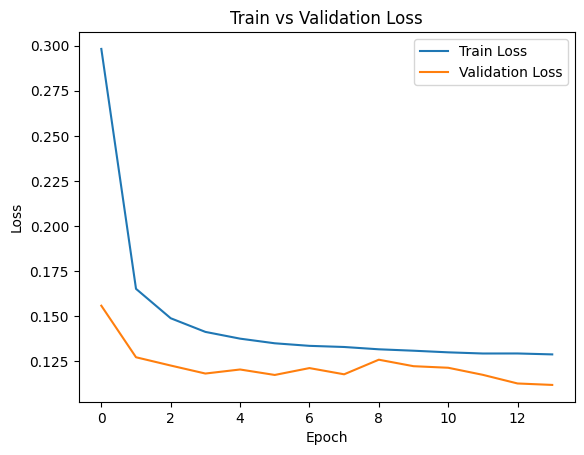

In [17]:
# Graficar las pérdidas
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

## Conclusión

Los resultados obtenidos reflejan una mejora progresiva en las métricas de validación, con una disminución constante en la pérdida y en el RMSE. Sin embargo, las restricciones inherentes al diseño del experimento presentan desafíos específicos, como los derivados del conjunto de datos limitado y el learning rate cuidadosamente controlado. Algunos puntos clave son:

1. **Learning rate bajo**: Este valor deliberadamente pequeño (1e-5) fue elegido para garantizar un aprendizaje estable y progresivo. Aunque esto alarga los tiempos de convergencia, es particularmente adecuado en contextos como este, donde el conjunto de datos es pequeño y el modelo necesita adaptarse a patrones sutiles sin sobreajustarse.
2. **Tamaño del conjunto de datos**: Solo se utilizó información de tres meses por año, lo que limita la diversidad y cantidad de datos para capturar completamente las dinámicas del afloramiento costero.
3. **Reducción estacional**: Aunque los meses seleccionados coinciden con el pico del fenómeno, el modelo no tiene exposición a transiciones estacionales que podrían proporcionar información valiosa sobre las dinámicas de inicio y finalización del afloramiento.
4. **Impacto en capas superficiales**: Aunque estas capas son críticas para estudiar el afloramiento, la ausencia de datos de niveles más profundos podría limitar una comprensión integral del fenómeno.

A pesar de estos desafíos, el modelo demuestra su capacidad para adaptarse a los datos disponibles, mostrando una convergencia estable y un descenso notable en las métricas de error. Este comportamiento indica que el enfoque del learning rate bajo ha sido adecuado para explorar el rango ideal de aprendizaje sin comprometer la estabilidad del entrenamiento.

Para mejorar el rendimiento en futuros experimentos, se sugieren las siguientes acciones:

- **Explorar otros valores de learning rate**: Realizar un barrido en hiperparámetros para confirmar que el valor seleccionado es óptimo o identificar alternativas mejores.
- **Ampliar el rango temporal de datos**: Incluir períodos de transición estacional para capturar patrones más amplios del afloramiento.
- **Aumentar la resolución de datos**: Tanto en el tiempo como en el espacio, para mejorar la precisión de las predicciones del modelo.
- **Utilizar capas oceánicas más profundas**: Para enriquecer la información sobre las dinámicas verticales del océano.

Este cuaderno demuestra cómo un enfoque meticuloso en el ajuste de parámetros, como el learning rate, y la selección de datos estacionales puede proporcionar información valiosa sobre el afloramiento costero y sentar las bases para futuros trabajos más robustos en modelado oceanográfico.